In [1]:
!pip install pingouin -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)

import pingouin as pg
from scipy.special import comb

### Step 4
Чтобы выяснить, как лучше преподавать статистику, преподаватели разбили студентов на пять групп. В каждой группе использовалась различная методика преподавания. В конце года каждая группа написала итоговую работу. Таким образом, сравнивалось пять групп по среднему баллу контрольной работы. Был применен однофакторный дисперсионный анализ, по результатам которого удалось отклонить нулевую гипотезу о равенстве средних. 

Сколько сравнений необходимо произвести, чтобы попарно сравнить все группы между собой?

In [6]:
comb(5, 2)

10.0

### Step 5
Необходимо ли применять поправку на множественное сравнение при сравнении групп из предыдущего вопроса между собой?

**Да, т.к. возрастает вероятность совершить ошибку первого рода.**

### Step 6
Курение считают основным фактором, предрасполагающим к хроническим заболеваниям легких. Однако пассивное курение таким фактором обычно не считается. Группа исследователей усомнилась в безвредности пассивного курения и исследовали проходимость дыхательных путей у некурящих, пассивных и активных курильщиков. В качестве зависимой переменной выступал один из показателей функции внешнего дыхания — максимальная объемная скорость середины выдоха. Исследователям удалось отклонить основную нулевую гипотезу о равенстве средних при p<0.05.

Для попарного сравнения всех групп между собой использовалась поправка Бонферрони. Различия между группами признавались статистически достоверными, если p-уровень значимости:

In [7]:
comb(3, 2)

3.0

In [10]:
round((1 - 0.95) / 3, 3)

0.017

# Мини-проект

На этот раз ситуация следующая: вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами двух тестов:

В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные 
Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый
Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

In [11]:
import requests
from urllib.parse import urlencode

In [12]:
def get_ydisk_url(public_key: str) -> str:
  """Returns url from YandexDisc api"""
  base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
  final_url = base_url + urlencode(dict(public_key=public_key))
  response = requests.get(final_url)
  download_url = response.json()['href']
  return download_url

In [13]:
pk_1 = 'https://disk.yandex.ru/d/iRcyB5PS8JB1lw'
pk_2 = 'https://disk.yandex.ru/d/NqeZSGmq5O3iFw'

In [14]:
task_1 = pd.read_csv(get_ydisk_url(pk_1))
task_2 = pd.read_csv(get_ydisk_url(pk_2))

### Step 2
Итак, первая задача: нужно проверить, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего. Всего пользователям показывались три варианта:

A – прямоугольные 16:9
B – квадратные
C – прямоугольные 12:4
Каким статистическим тестом нужно воспользоваться для сравнения средних в данном случае?

**ANOVA**

### Step 3
Проверьте, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.

Hint: scipy.stats.levene либо pingouin.homoscedasticity



In [15]:
task_1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [17]:
task_1['group'].value_counts()

A    10000
B    10000
C    10000
Name: group, dtype: int64

In [30]:
A = task_1[task_1['group'] == 'A']['events']
B = task_1[task_1['group'] == 'B']['events']
C = task_1[task_1['group'] == 'C']['events']

In [19]:
pg.homoscedasticity(data=task_1, dv='events', group='group')

,W,pval,equal_var
levene,2.26226,0.104133,True


### Step 4
Также убедитесь, что данные распределены нормально - тем же способом, что и в прошлом уроке.

Дополнительно: сравните  результат с qq-графиками. Какой вывод можно сделать по совокупности этих методов?

Выберите верные утверждения:

In [20]:
pg.normality(data=task_1, dv='events', group='group', method='normaltest')

,W,pval,normal
group,,,
A,2.103460,0.349333,True
B,0.841072,0.656695,True
C,3.243726,0.197530,True


<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

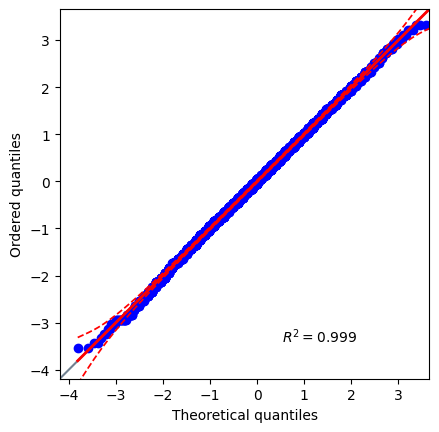

In [32]:
pg.qqplot(A)

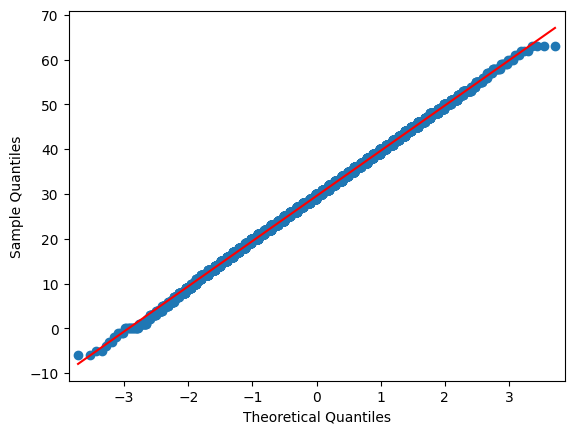

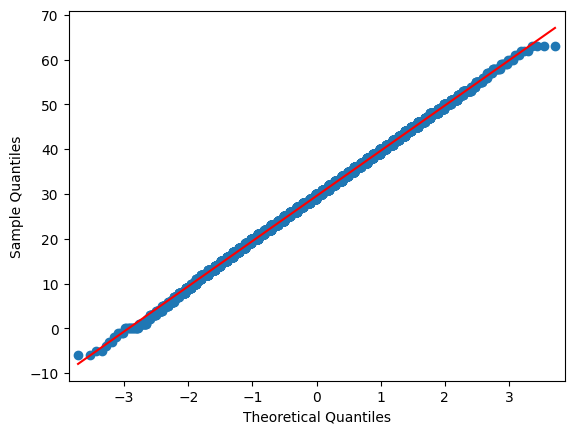

In [29]:
sm.qqplot(A, line='r')

### Step 5
Самое время провести тест! 

In [33]:
pg.welch_anova(data=task_1, dv='events', between='group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,19996.209267,2924.792424,0.0,0.161377


In [34]:
ss.f_oneway(A, B, C)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

### Step 6
Теперь используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия. 

Дополнительно: попробуйте другие варианты поправок на множественные сравнения через pingouin. Дают ли они те же выводы, что и Тьюки?

In [35]:
pg.pairwise_tukey(data=task_1, dv='events', between='group')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.0,-0.806229
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.0,0.210514
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.0,1.024138


In [36]:
pg.pairwise_gameshowell(data=task_1, dv='events', between='group')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140920,-57.011134,19987.258491,6.412648e-13,-0.806229
1,A,C,29.5796,27.4703,2.1093,0.141696,14.886135,19995.116233,6.349254e-12,0.210514
2,B,C,37.6136,27.4703,10.1433,0.140062,72.420220,19995.502469,0.000000e+00,1.024138


### Step 7
Так какие картинки в итоге будем использовать?

<Axes: xlabel='group', ylabel='events'>

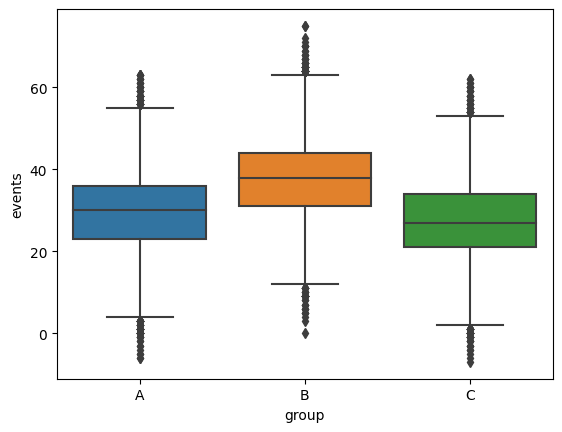

In [37]:
sns.boxplot(data=task_1, x='group', y='events')

# Step 8
Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.
Какой метод скорее всего пригодится в данном случае?

**многофакторный дисперсионный анализ**

### Step 9
Посмотрим на данные. Для начала визуализируйте распределение events для контрольной и тестовой групп. Соотнесите графики распределения и экспериментальные группы:

In [38]:
task_2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [39]:
task_2['group'].value_counts()

test       50000
control    50000
Name: group, dtype: int64

In [40]:
test = task_2[task_2['group'] == 'test']['events']
control = task_2[task_2['group'] == 'control']['events']

<Axes: title={'center': 'control'}, xlabel='events', ylabel='Count'>

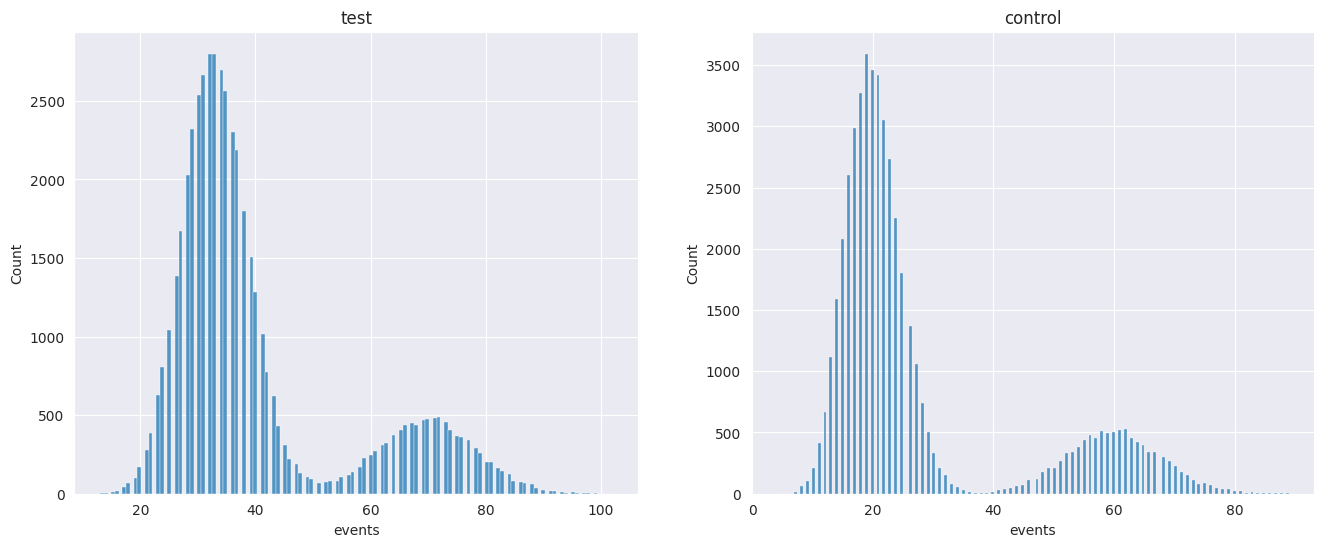

In [56]:
plt.figure(figsize=(16, 6))
sns.set_style('darkgrid')
plt.subplot(1, 2, 1)
plt.title('test')
sns.histplot(test)
plt.subplot(1, 2, 2)
plt.title('control')
sns.histplot(control)

### Step 10
Посчитайте среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя. 

В качестве ответа укажите стандартное отклонение для пользователей из сегмента high и контрольной группы, с точностью до 2 знаков после точки.

In [57]:
task_2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [61]:
task_2.query('(segment == "high") & (group == "control")')['events'].std().round(2)

7.81

### Step 11
Почти у цели – осталось выбрать формулу для модели. Напомним, что мы хотим проверить эффект нескольких переменных – group и segment – на events, с взаимодействием факторов.

Если вы прибегнете к statsmodels, то какую формулу используете?

In [64]:
# model = smf.ols('events ~C(segment)*C(group)', data=task_2).fit()
# anova_lm(model)

### Step 12
Проведите тест (через anova_lm либо pg.anova), а затем используйте критерий Тьюки, чтобы понять между какими группами есть статистически значимые различия.

В данном случае для последующих сравнений между группами можно проделать следующую операцию: соединить колонки group и segment в combination, чтобы потом передать в аргумент groups в MultiComparison либо pairwise_tukey:
Между какими группами были обнаружены статистически значимые различия? Выберите верные утверждения:

In [65]:
pg.anova(data=task_2, dv='events', between=['segment', 'group'])

,Source,SS,DF,MS,F,p-unc,np2
0,segment,2.362480e+07,1.0,2.362480e+07,689756.377484,0.000000e+00,0.873383
1,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
2,segment * group,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


In [71]:
task_2['combination'] = task_2['group'] + '\\' + task_2['segment']

In [72]:
task_2.head()

,id,group,segment,events,combination
0,83440,test,high,78.0,test\high
1,96723,test,high,71.0,test\high
2,68719,test,high,80.0,test\high
3,50399,test,high,80.0,test\high
4,95613,test,high,78.0,test\high


In [74]:
pg.pairwise_tukey(data=task_2, dv='events', between='combination')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,control\high,control\low,59.970800,20.031575,39.939225,0.065432,610.391461,0.0,7.521612
1,control\high,test\high,59.970800,69.938500,-9.967700,0.082766,-120.432523,0.0,-1.228989
2,control\high,test\low,59.970800,33.025925,26.944875,0.065432,411.798717,0.0,4.350026
3,control\low,test\high,20.031575,69.938500,-49.906925,0.065432,-762.727892,0.0,-9.091140
4,control\low,test\low,20.031575,33.025925,-12.994350,0.041383,-314.002699,0.0,-2.530414
5,test\high,test\low,69.938500,33.025925,36.912575,0.065432,564.135148,0.0,5.814008


In [75]:
pairwise_tukeyhsd(task_2['events'], task_2['combination']).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control\high,control\low,-39.9392,0.0,-40.1073,-39.7711,True
control\high,test\high,9.9677,0.0,9.7551,10.1803,True
control\high,test\low,-26.9449,0.0,-27.113,-26.7768,True
control\low,test\high,49.9069,0.0,49.7388,50.075,True
control\low,test\low,12.9944,0.0,12.888,13.1007,True
test\high,test\low,-36.9126,0.0,-37.0807,-36.7445,True


### Step 13
Визуализируйте результаты теста и заполните пропуски:

<Axes: xlabel='group', ylabel='events'>

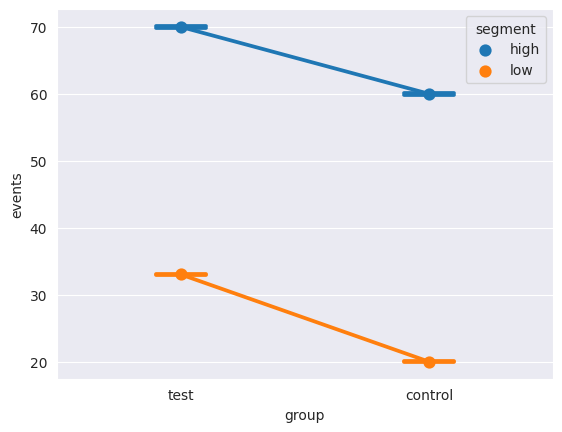

In [76]:
sns.pointplot(data=task_2, x='group', y='events', hue='segment', capsize=0.2)

Фактор group оказался 
ЗНАЧИМЫМ
, фактор segment – 
ЗНАЧИМЫМ
, их взаимодействие – 
ЗНАЧИМО
. Судя по графику, для всех групп среднее значение events 
УВЕЛИЧИЛОСЬ
, поэтому решение: 
ВЫКАТЫВАЕМ НОВУЮ ВЕРСИЮ
.